In [1]:
import time

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from models import MLP
from shaps import *
from utils import get_cc, mc_mlp_val, mse, variance_analysis, compute_error

np.random.seed(5)
os.environ["CUDA_VISIBLE_DEVICES"]="2"

## Hyperparameters

The maximum number of features used to compute the exact Shapely values.

In [2]:
n_features = 15

## Preprocessing

Download and perform some basic preprocessing to the dataset.

In [3]:
df = get_cc()
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


z-score normalization and xs and ys separation

In [4]:
xs = df[df.columns.difference(['default.payment.next.month'])].apply(zscore)
ys = df[['default.payment.next.month']]

select only the first n features

In [5]:
xs = xs[df.columns[:n_features]]

train and test split (8:2)

In [6]:
x_train, x_test, y_train, y_test = \
    train_test_split(xs, ys, test_size=0.2)

for convenience we add bias column to the dataset

In [7]:
x_train.insert(loc=0, column='bias', value=np.ones(x_train.shape[0]))
x_test.insert(loc=0, column='bias', value=np.ones(x_test.shape[0]))
n_features += 1

## Validate MLP

In [8]:
hidden_layers = range(0, 4)
nodes_hidden_layers = range(1, 16)

max_conf, max_acc = mc_mlp_val(x_train, y_train, n_features, hidden_layers, nodes_hidden_layers)

print(max_acc, max_conf)

100%|██████████| 1000/1000 [2:55:29<00:00, 10.53s/it] 

0.8247444633730835 (16, 13, 9, 2)


## Train MLP

Train and test the best MLP found by the validation procedure.

In [9]:
model = MLP(max_conf, use_bias_input=False)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50, batch_size=300, validation_split=0, verbose=0)

model.evaluate(x_test, y_test, batch_size=300)

20/20 [==============================] - 0s 1ms/step - loss: 0.4315 - accuracy: 0.8223


[0.4315243797394836, 0.8223471299608244]

## Analysis of Variance

Randomly select n examples from the test set. These will be used to compute the Shapely values.

In [10]:
n_examples = 50
example_is = np.random.randint(0, len(x_test), n_examples)
examples = x_test.iloc[example_is,:].values

Set the number of runs for all the Shapely methods.
The equivalent number of runs will be computed for each method.

In [11]:
runs = 100
runs_per_split = 2

### Owen Sampling Halved

In [12]:
avg_stds_owen_sam_shap_halved = \
    variance_analysis(model, 
                      examples,
                      lambda e, m, y, i: owen_sam_shap_halved(e, m, y, runs=runs_per_split, q_splits=i),
                      runs)

100%|██████████| 50/50 [02:19<00:00,  2.79s/it]


### Owen Sampling

In [13]:
avg_stds_owen_sam_shap = \
    variance_analysis(model, 
                      examples, 
                      lambda e, m, y, i: owen_sam_shap(e, m, y, runs=runs_per_split, q_splits=i),
                      runs)

100%|██████████| 50/50 [02:22<00:00,  2.84s/it]


### Castro Sampling

In [14]:
avg_stds_castro_sam_shap = \
    variance_analysis(model, 
                      examples, 
                      lambda e, m, y, i: castro_sam_shap(e, m, y, runs=i*runs_per_split), 
                      runs)

100%|██████████| 50/50 [02:55<00:00,  3.51s/it]


### Plot

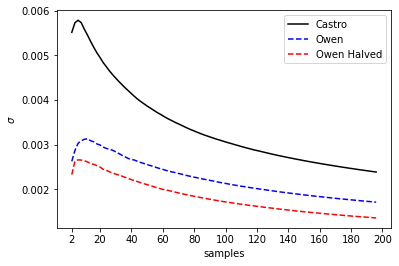

In [15]:
xs = list(np.arange(runs_per_split, (runs-1)*runs_per_split, step=runs_per_split))

plt.plot(xs, avg_stds_castro_sam_shap[2:], 'black', label='Castro')
plt.plot(xs, avg_stds_owen_sam_shap[2:], 'b--', label='Owen')
plt.plot(xs, avg_stds_owen_sam_shap_halved[2:],'r--', label='Owen Halved')
plt.xticks(([runs_per_split] + list(np.arange(0, runs*runs_per_split+10, step=20)[1:])))
plt.xlabel('samples')
plt.ylabel('$\\sigma$')
plt.legend()
plt.savefig('imgs/variance_analysis_cc.png', dpi=600)

## Error Analysis

Also here we need to select n examples from the test set.
We reuse those already selected above.

Set the number of runs for all the Shapely methods.
The equivalent number of runs will be computed for each method.

In [16]:
runs = 1000
runs_per_split = 2

### Exact Shapley Values

In [17]:
cache_phi_exact = {}

for k in tqdm(range(examples.shape[0])):
    example = examples[k,:]
    y_hat = np.argmax(model.predict(example[np.newaxis]))
    phi_exact = np.zeros(example.shape[0])
    for i in range(example.shape[0]):
        phi_exact[i] = shap_exact(i, example, model, y_hat)
    cache_phi_exact[k] = phi_exact

100%|██████████| 50/50 [15:15:32<00:00, 1098.66s/it]  


### Castro Sampling

In [18]:
error_castro = \
    compute_error(model, 
                  examples,       
                  cache_phi_exact,       
                  lambda e, m, y, i: castro_sam_shap(e, m, y, runs=i*runs_per_split), 
                  runs = runs)

100%|██████████| 50/50 [06:38<00:00,  7.97s/it]


### Owen Sampling

In [19]:
error_owen = \
    compute_error(model, 
                  examples,       
                  cache_phi_exact,       
                  lambda e, m, y, i: owen_sam_shap(e, m, y, runs=runs_per_split, q_splits=i),
                  runs = runs)

100%|██████████| 50/50 [02:01<00:00,  2.42s/it]


### Halved Owen Sampling

In [20]:
error_owen_halved = \
    compute_error(model, 
                  examples,       
                  cache_phi_exact,       
                  lambda e, m, y, i: owen_sam_shap_halved(e, m, y, runs=runs_per_split, q_splits=i),
                  runs = runs)

100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


### Print Statistics

In [21]:
print('Error:')
print('Castro = ', np.mean(error_castro))
print('Owen = ', np.mean(error_owen))
print('Owen Halved = ', np.mean(error_owen_halved))

Error:
Castro =  3.1639918499689733e-07
Owen =  2.1285628759063755e-07
Owen Halved =  1.0596139357293915e-07


### Plot Box Plots

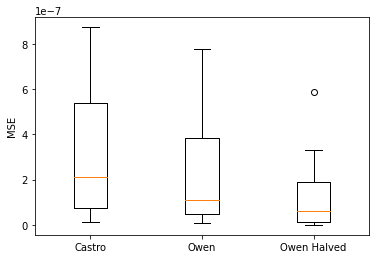

In [22]:
data = [error_castro, error_owen, error_owen_halved]

plt.boxplot(data)
plt.xticks(range(1, 4), labels=['Castro', 'Owen', 'Owen Halved'])
plt.ylabel('MSE')

plt.savefig('imgs/error_methods_cc.png', dpi=600)

### Changing Runs

We propose the same analysis we perform above but varying the number of runs.

In [23]:
max_runs = 100
xs = []
for r in range(1, max_runs + 1):
    xs.append(r*runs_per_split)

#### Castro Sampling

In [24]:
error_castro = []
for r in tqdm(range(1, max_runs + 1)):
    error = \
        compute_error(model, 
                      examples, 
                      cache_phi_exact, 
                      lambda e, m, y, i: castro_sam_shap(e, m, y, runs=i*runs_per_split), 
                      runs = r, tqdm_disable = True)
    error_castro.append(np.mean(error))

100%|██████████| 100/100 [2:38:11<00:00, 94.92s/it]  


#### Owen Sampling

In [25]:
error_owen = []
for r in tqdm(range(1, max_runs + 1)):
    error = \
        compute_error(model, 
                      examples, 
                      cache_phi_exact, 
                      lambda e, m, y, i: owen_sam_shap(e, m, y, runs=runs_per_split, q_splits=i),
                      runs = r, tqdm_disable = True)
    error_owen.append(np.mean(error))

100%|██████████| 100/100 [2:01:09<00:00, 72.70s/it]


#### Owen Sampling Halved

In [27]:
error_owen_halved = []
for r in tqdm(range(1, max_runs + 1)):
    error = \
        compute_error(model, 
                      examples, 
                      cache_phi_exact, 
                      lambda e, m, y, i: owen_sam_shap_halved(e, m, y, runs=runs_per_split, q_splits=i),
                      runs = r, tqdm_disable = True)
    error_owen_halved.append(np.mean(error))

100%|██████████| 100/100 [1:58:55<00:00, 71.36s/it]


### Plot

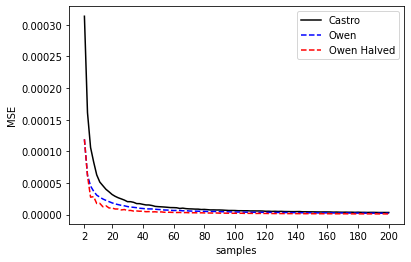

In [28]:
plt.plot(xs, error_castro, 'black', label='Castro')
plt.plot(xs, error_owen, 'b--', label='Owen')
plt.plot(xs, error_owen_halved,'r--', label='Owen Halved')
plt.xticks(([runs_per_split] + list(np.arange(0, xs[-1]+10, step=runs_per_split*10)[1:])))
plt.xlabel('samples')
plt.ylabel('MSE')
plt.legend()
plt.savefig('imgs/error_analysis_changing_runs_cc.png', dpi=600)